# Contributions
All members contributed to the development of RL agents and production of this report equally.

**Team Members:**   
Oscar   
Asher   
Justin   




# Import Dependencies


In [1]:
import numpy as np
import gym
import pickle
import matplotlib.pyplot as plt

from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data=''''''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

# Load Cartpole Environment

Here we will create the cartpole environment using the gym library. Then we will check the action space and observation space to get a overview of this environment.   

### Action Space
The action is an ndarray with shape (1,) which can take values {0, 1} indicating pushing the cart to the left or right, respectively. Note that the velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it.   

### Observation Space
The observation is an ndarray with shape (4,) with the values corresponding to the following positions and velocities:

In [2]:
env = gym.make('CartPole-v1')
print("Shape of action space: ",env.action_space)
print("Shape of observation space: ", env.observation_space.shape[0])

Shape of action space:  Discrete(2)
Shape of observation space:  4


---

# Task 1: Development of an RL agent

In this section, we will develop several RL agent for comparison

## 1.1 Develpoing Q-learning Agent

The first agent we will implement is the Q-learning agent which is an off-policy reinforcement learning that will find the bet course of action given the current state of the agent.

#### Q-Learning Equation

$$ Q_{new}(S_{t}, A_{t}) \leftarrow Q_{old}(S_{t}, A_{t}) + \alpha (R_{t+1}+ \gamma \underset{a}{max} Q_{old}(S_{t+1}, a) - Q_{old}(S_{t}, A_{t})) $$

We implemented our Q-agent using the formula taught in lecture for updating the Q-table.   

#### Exploration Rate   

We introduced epsilon and epsilon decay which is the exploration rate. This is to encourage exploration during the beginning of the training. Exploration rate should decrease as the agent gain more experience to reduce the randomness of actions.   


In [3]:
class QLearningAgent:
    """Q-Learning agent

    Attributes:
        env: OpenAI Gym environment
        q: Q table
        pos_space: position space
        vel_space: velocity space
        ang_space: pole angle space
        ang_vel_space: pole angular velocity space
        alpha: learning rate
        gamma: discount factor
        epsilon: exploration rate
        epsilon_decay: exploration rate decay
    """
    def __init__(self, env):
        # Environment
        self.env = env

        # Divide position, velocity, pole angle, and pole angular velocity into segments
        self.pos_space = np.linspace(-2.4, 2.4, 7) 
        self.vel_space = np.linspace(-4.0, 4.0, 7) 
        self.ang_space = np.linspace(-.2095, .2095, 7)
        self.ang_vel_space = np.linspace(-4.0, 4.0, 7)

        # Initialize Q table
        self.q = np.zeros((len(self.pos_space)+1, len(self.vel_space)+1, len(self.ang_space)+1, len(self.ang_vel_space)+1, self.env.action_space.n)) 

        # Hyperparameters
        self.alpha = 0.1 # learning rate
        self.gamma = 0.95 # discount factor
        self.epsilon = 0.1 # exploration rate
        self.epsilon_decay = 0.00001 # exploration rate decay

        self.rng = np.random.default_rng() # Random number generator

    """Run one episode of the environment
    
    Args:
        is_training: boolean to indicate if the agent is training or testing
    """
    def run_one_episode(self, is_training=True):
        # Get initial state
        state = self.env.reset()[0]

        # Discretize state
        state_p = np.digitize(state[0], self.pos_space) 
        state_v = np.digitize(state[1], self.vel_space)
        state_a = np.digitize(state[2], self.ang_space)
        state_av = np.digitize(state[3], self.ang_vel_space)

        # Initialize variables
        terminated = False
        rewards = 0

        # Loop through one episode
        while(not terminated):
            # Choose action based on epsilon-greedy policy
            if is_training and np.random.uniform() < self.epsilon:
                action = self.env.action_space.sample()
            else:
                action = np.argmax(self.q[state_p, state_v, state_a, state_av, :]) # Choose action based on Q table
         
              
            # Take action, get new state and reward
            new_state, reward, terminated, _, _ = self.env.step(action)
            new_state_p = np.digitize(new_state[0], self.pos_space)
            new_state_v = np.digitize(new_state[1], self.vel_space)
            new_state_a = np.digitize(new_state[2], self.ang_space)
            new_state_av = np.digitize(new_state[3], self.ang_vel_space)
            # Update Q table based on Bellman equation
            if is_training:
                self.q[state_p, state_v, state_a, state_av, action] = self.q[state_p, state_v, state_a, state_av, action] + self.alpha * (
                    reward + self.gamma*np.max(self.q[new_state_p, new_state_v, new_state_a, new_state_av,:]) - self.q[state_p, state_v, state_a, state_av, action]
                )
            # Update state
            state = new_state
            state_p = new_state_p
            state_v = new_state_v
            state_a = new_state_a
            state_av = new_state_av
            rewards += reward
        return rewards
    
    """
    Train the agent
    
    Args:
        min_rewards: minimum rewards to stop training
        plot: boolean to indicate if the rewards should be plotted
    """
    def train(self, min_rewards=300, plot=False):
        rewards_per_episode = []
        i = 0

        # Loop through episodes
        while True:
            rewards = self.run_one_episode() # Run one episode
            rewards_per_episode.append(rewards) # Append rewards
            mean_rewards = np.mean(rewards_per_episode[max(0, len(rewards_per_episode)-100):]) # Mean rewards of last 100 episodes
            if i%100==0:
                print(f'Episode: {i} Rewards: {rewards}  Epsilon: {self.epsilon:0.2f}  Mean Rewards {mean_rewards:0.1f}')
            if mean_rewards > min_rewards:
                break
            self.epsilon = max(self.epsilon - self.epsilon_decay, 0.1) # Decay epsilon
            i += 1
        self.env.close()

        # plot rewards
        if plot:
            self.plot_rewards(rewards_per_episode)

    """
    Train the agent by episodes
    
    Args:
        num_episodes: number of episodes to train
        plot: boolean to indicate if the rewards should be plotted
    """
    def train_by_episodes(self, num_episodes=1000, plot=False):
        rewards_per_episode = []
        for i in range(num_episodes):
            rewards = self.run_one_episode()
            rewards_per_episode.append(rewards)
            mean_rewards = np.mean(rewards_per_episode[max(0, len(rewards_per_episode)-100):])
            if i%100==0:
                print(f'Episode: {i} Rewards: {rewards}  Epsilon: {self.epsilon:0.2f}  Mean Rewards {mean_rewards:0.1f}')
            self.epsilon = max(self.epsilon - self.epsilon_decay, 0.01)
        self.env.close()

        # plot rewards
        if plot:
            self.plot_rewards(rewards_per_episode)
    

    """
    Test the agent
    
    Args:
        num_episodes: number of episodes to test
        plot: boolean to indicate if the rewards should be plotted
    """
    def test(self, num_episodes=100, plot=True):
        rewards_per_episode = []
        for i in range(num_episodes):
            rewards = self.run_one_episode(is_training=False) # Run one episode
            rewards_per_episode.append(rewards) # Append rewards
            print(f'Episode: {i+1} Rewards: {rewards}')
        print(f'Cummulative average rewards: {np.mean(rewards_per_episode)}')

        # plot rewards
        if plot:
            plt.plot(rewards_per_episode)
            plt.xlabel('Episodes')
            plt.ylabel('Rewards')
            plt.title(f'Rewards vs Episodes)')
            plt.savefig('cartpoleQLAgent_test.png')
        
        return np.mean(rewards_per_episode)

    """
    Show the action

    """
    def show_action(self):
        # Get initial state
        state = self.env.reset()[0]

        # Discretize state
        state_p = np.digitize(state[0], self.pos_space)
        state_v = np.digitize(state[1], self.vel_space)
        state_a = np.digitize(state[2], self.ang_space)
        state_av = np.digitize(state[3], self.ang_vel_space)

        # Choose action based on Q table
        action = np.argmax(self.q[state_p, state_v, state_a, state_av, :]) 

        # Return state and action
        return state, action

    """
    Get the action

    Args:
        state: state of the environment
    """
    def predict(self, state):
        state_p = np.digitize(state[0], self.pos_space)
        state_v = np.digitize(state[1], self.vel_space)
        state_a = np.digitize(state[2], self.ang_space)
        state_av = np.digitize(state[3], self.ang_vel_space)
        action = np.argmax(self.q[state_p, state_v, state_a, state_av, :])
        return action

    """
    Save and load the model
    
    Args:
        filename: name of the file to save/load the model
    """
    def save_model(self, filename='cartpoleQLAgent.pkl'):
        with open(filename, 'wb') as f:
            pickle.dump(self.q, f)

    """
    Load the model
    
    Args:
        filename: name of the file to load the model
    """
    def load_model(self, filename='cartpoleQLAgent.pkl'):
        with open(filename, 'rb') as f:
            self.q = pickle.load(f)

    """
    Plot the rewards
    
    Args:
        rewards_array: array of rewards
    """
    def plot_rewards(self, rewards_array):
        mean_rewards = []
        for t in range(len(rewards_array)):
            mean_rewards.append(np.mean(rewards_array[max(0, t-100):(t+1)]))
        plt.plot(mean_rewards)
        plt.xlabel('Episodes')
        plt.ylabel('Mean Rewards')
        plt.title(f'Mean Rewards vs Episodes (lr={self.alpha}, er={self.epsilon:0.2f})')
        plt.savefig('cartpoleQLAgent.png')


Episode: 0 Rewards: 10.0  Epsilon: 0.10  Mean Rewards 10.0
Episode: 100 Rewards: 10.0  Epsilon: 0.10  Mean Rewards 10.0
Episode: 200 Rewards: 10.0  Epsilon: 0.10  Mean Rewards 9.9


c:\Users\User\Documents\NTU WORK\SC3000-Projects\sc3000\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 300 Rewards: 14.0  Epsilon: 0.10  Mean Rewards 18.6
Episode: 400 Rewards: 48.0  Epsilon: 0.10  Mean Rewards 24.5
Episode: 500 Rewards: 24.0  Epsilon: 0.10  Mean Rewards 31.5
Episode: 600 Rewards: 33.0  Epsilon: 0.10  Mean Rewards 39.4
Episode: 700 Rewards: 42.0  Epsilon: 0.10  Mean Rewards 47.4
Episode: 800 Rewards: 54.0  Epsilon: 0.10  Mean Rewards 67.8
Episode: 900 Rewards: 72.0  Epsilon: 0.10  Mean Rewards 91.9
Episode: 1000 Rewards: 102.0  Epsilon: 0.10  Mean Rewards 99.9


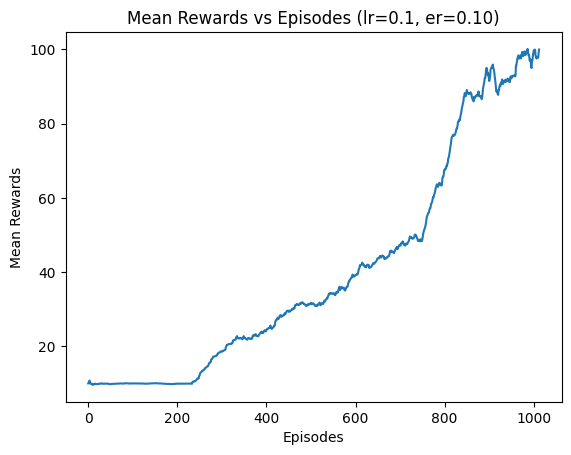

In [4]:
# Train the agent to reach a minimum of 100 avg rewards
agent = QLearningAgent(env)
agent.train(min_rewards=100, plot=True)
agent.save_model()

### Correctness of Implementation
Print the values of the state and chosen action in Jupyter notebook.

In [5]:
state, action = agent.show_action()
print(f"Returned Observations: {state}")
print(f"Returned Chosen Action: {action}")

Returned Observations: [ 0.01094855 -0.00872525 -0.03078592  0.02279062]
Returned Chosen Action: 1


## 1.2 Hyperparameter Exploration and Tuning

#### Vary Learning Rate

What we want to do now is to investigate the effect of different initial learning rate on the number of episodes needed to reach an average reward of 200.

Here we look at learning rate at 0.05, 0.1, 0.15, 0.2 while keeping the initial exploration rate at 0.1

Episode: 0 Rewards: 10.0  Epsilon: 0.10  Mean Rewards 10.0
Episode: 100 Rewards: 10.0  Epsilon: 0.10  Mean Rewards 10.0
Episode: 200 Rewards: 9.0  Epsilon: 0.10  Mean Rewards 10.2
Episode: 300 Rewards: 8.0  Epsilon: 0.10  Mean Rewards 10.1
Episode: 400 Rewards: 14.0  Epsilon: 0.10  Mean Rewards 10.5
Episode: 500 Rewards: 9.0  Epsilon: 0.10  Mean Rewards 10.3
Episode: 600 Rewards: 16.0  Epsilon: 0.10  Mean Rewards 17.7
Episode: 700 Rewards: 31.0  Epsilon: 0.10  Mean Rewards 20.8
Episode: 800 Rewards: 19.0  Epsilon: 0.10  Mean Rewards 21.4
Episode: 900 Rewards: 9.0  Epsilon: 0.10  Mean Rewards 17.6
Episode: 1000 Rewards: 22.0  Epsilon: 0.10  Mean Rewards 25.1
Episode: 1100 Rewards: 54.0  Epsilon: 0.10  Mean Rewards 27.8
Episode: 1200 Rewards: 23.0  Epsilon: 0.10  Mean Rewards 27.6
Episode: 1300 Rewards: 72.0  Epsilon: 0.10  Mean Rewards 32.1
Episode: 1400 Rewards: 19.0  Epsilon: 0.10  Mean Rewards 26.5
Episode: 1500 Rewards: 45.0  Epsilon: 0.10  Mean Rewards 33.1
Episode: 1600 Rewards: 4

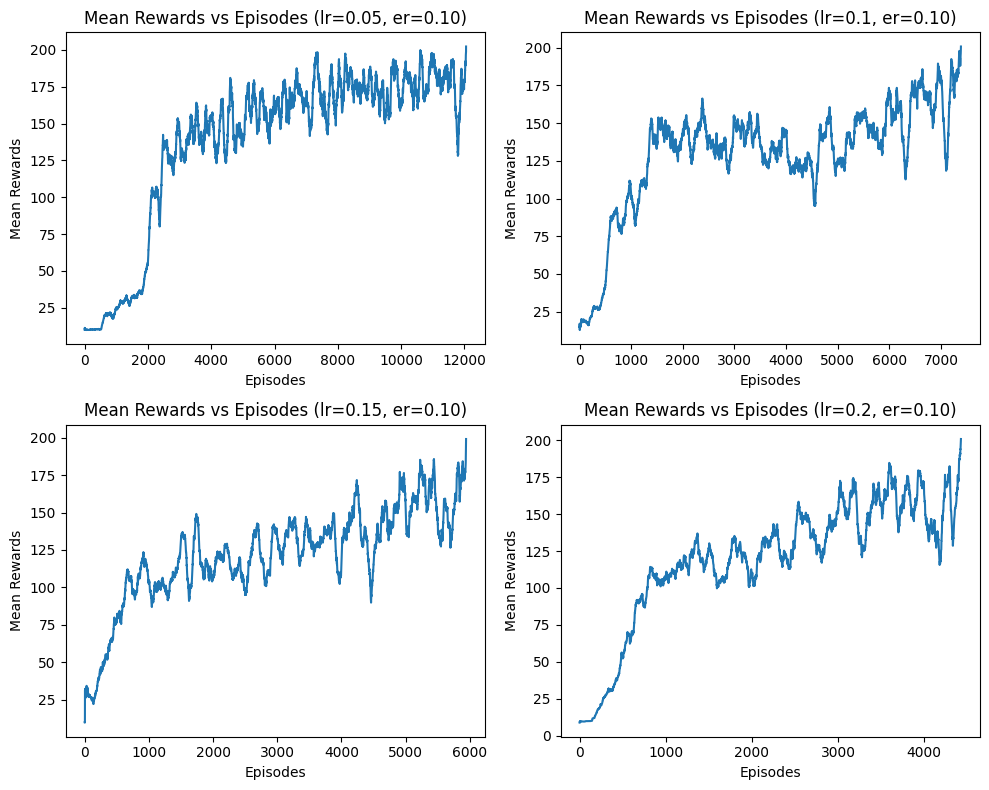

In [6]:
# Define learning rates
learning_rates = [0.05, 0.1, 0.15, 0.2]

agent = QLearningAgent(env) # Create a new agent

plt.figure(figsize=(10, 8)) # Create a figure to plot the rewards

i = 0
# Train the agent with different learning rates
for alpha in learning_rates:
    plt.subplot(2,2,i+1)
    agent.alpha = alpha # set learning rate
    agent.epsilon = 0.1 # reset epsilon
    agent.q = np.zeros((len(agent.pos_space)+1, len(agent.vel_space)+1, len(agent.ang_space)+1, len(agent.ang_vel_space)+1, agent.env.action_space.n)) # reset Q table
    
    agent.train(min_rewards=200, plot=True)
    # agent.save_model(f'cartpoleQLAgent_lr{alpha}.pkl')
    i += 1

plt.tight_layout()

#### Vary Initial Exploration Rate

What we want to do now is to investigate the effect of different initial exploration rate on the number of episodes needed to reach an average reward of 200.

Here we look at initial exploration rate at 0.1, 0.2, 0.3, 0.4 while keeping the initial learning rate of 0.1

Episode: 0 Rewards: 9.0  Epsilon: 0.10  Mean Rewards 9.0
Episode: 100 Rewards: 13.0  Epsilon: 0.10  Mean Rewards 24.1
Episode: 200 Rewards: 16.0  Epsilon: 0.10  Mean Rewards 22.8
Episode: 300 Rewards: 13.0  Epsilon: 0.10  Mean Rewards 36.4
Episode: 400 Rewards: 37.0  Epsilon: 0.10  Mean Rewards 39.3
Episode: 500 Rewards: 40.0  Epsilon: 0.10  Mean Rewards 62.2
Episode: 600 Rewards: 24.0  Epsilon: 0.10  Mean Rewards 57.8
Episode: 700 Rewards: 76.0  Epsilon: 0.10  Mean Rewards 61.8
Episode: 800 Rewards: 140.0  Epsilon: 0.10  Mean Rewards 72.6
Episode: 900 Rewards: 79.0  Epsilon: 0.10  Mean Rewards 106.2
Episode: 1000 Rewards: 132.0  Epsilon: 0.10  Mean Rewards 101.2
Episode: 1100 Rewards: 121.0  Epsilon: 0.10  Mean Rewards 109.7
Episode: 1200 Rewards: 67.0  Epsilon: 0.10  Mean Rewards 114.2
Episode: 1300 Rewards: 62.0  Epsilon: 0.10  Mean Rewards 122.0
Episode: 1400 Rewards: 145.0  Epsilon: 0.10  Mean Rewards 106.1
Episode: 1500 Rewards: 118.0  Epsilon: 0.10  Mean Rewards 114.8
Episode: 1

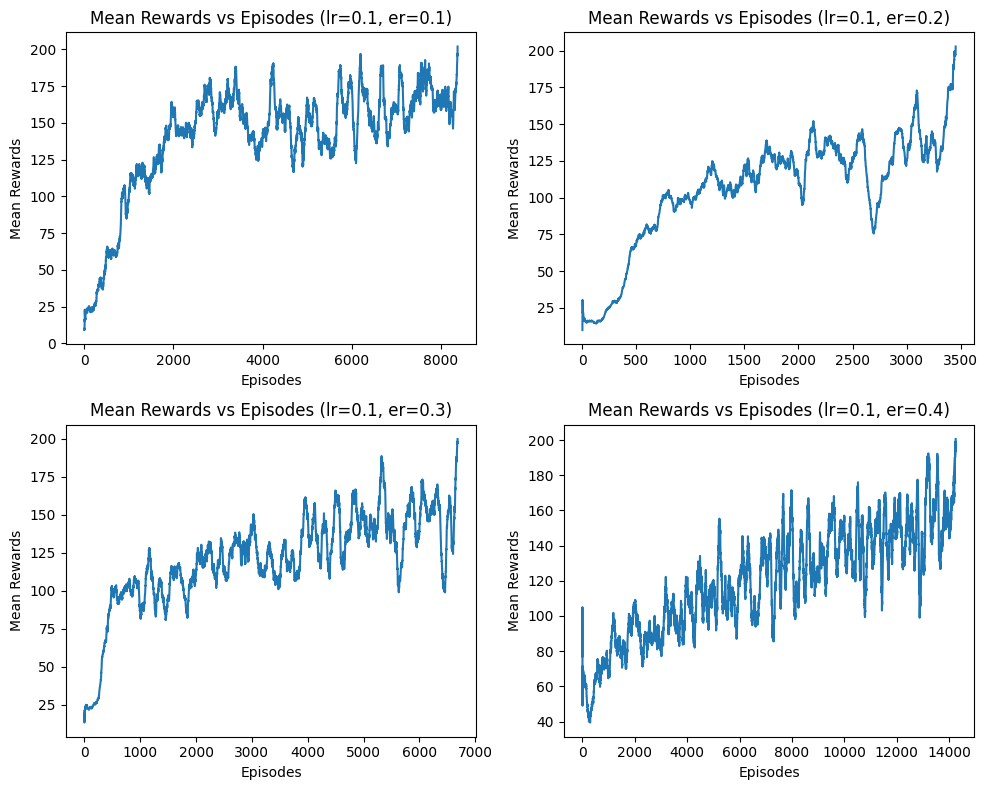

In [7]:
# Define exploration rates
exploration_rates = [0.1, 0.2, 0.3, 0.4]

agent = QLearningAgent(env) # Create a new agent

plt.figure(figsize=(10, 8)) # Create a figure to plot the rewards

i = 0
# Train the agent with different exploration rates
for epsilon in exploration_rates:
    plt.subplot(2,2,i+1)
    agent.alpha = 0.1 # reset learning rate
    agent.epsilon = epsilon # set exploration rate
    agent.q = np.zeros((len(agent.pos_space)+1, len(agent.vel_space)+1, len(agent.ang_space)+1, len(agent.ang_vel_space)+1, agent.env.action_space.n)) # reset Q table
    
    agent.train(min_rewards=200, plot=True)
    plt.title(f'Mean Rewards vs Episodes (lr={0.1}, er={epsilon})')
    # agent.save_model(f'cartpoleQLAgent_epsilon{epsilon}.pkl')
    i += 1

plt.tight_layout()

#### Choosing the best hyper parameters

Having done a very basic preliminary investigation on the hyper parameters, we decided to choose learning rate of 0.15 and initial exploration rate of 0.2 for our agent.

Now we will train the agent using the choosen hyper parameters

Episode: 0 Rewards: 19.0  Epsilon: 0.20  Mean Rewards 19.0
Episode: 100 Rewards: 11.0  Epsilon: 0.20  Mean Rewards 11.8
Episode: 200 Rewards: 9.0  Epsilon: 0.20  Mean Rewards 13.3
Episode: 300 Rewards: 76.0  Epsilon: 0.20  Mean Rewards 24.6
Episode: 400 Rewards: 74.0  Epsilon: 0.20  Mean Rewards 54.0
Episode: 500 Rewards: 118.0  Epsilon: 0.19  Mean Rewards 73.0
Episode: 600 Rewards: 209.0  Epsilon: 0.19  Mean Rewards 98.3
Episode: 700 Rewards: 149.0  Epsilon: 0.19  Mean Rewards 94.7
Episode: 800 Rewards: 157.0  Epsilon: 0.19  Mean Rewards 113.3
Episode: 900 Rewards: 117.0  Epsilon: 0.19  Mean Rewards 102.3
Episode: 1000 Rewards: 84.0  Epsilon: 0.19  Mean Rewards 98.1
Episode: 1100 Rewards: 33.0  Epsilon: 0.19  Mean Rewards 81.0
Episode: 1200 Rewards: 133.0  Epsilon: 0.19  Mean Rewards 101.4
Episode: 1300 Rewards: 141.0  Epsilon: 0.19  Mean Rewards 106.7
Episode: 1400 Rewards: 167.0  Epsilon: 0.19  Mean Rewards 112.3
Episode: 1500 Rewards: 40.0  Epsilon: 0.18  Mean Rewards 99.7
Episode:

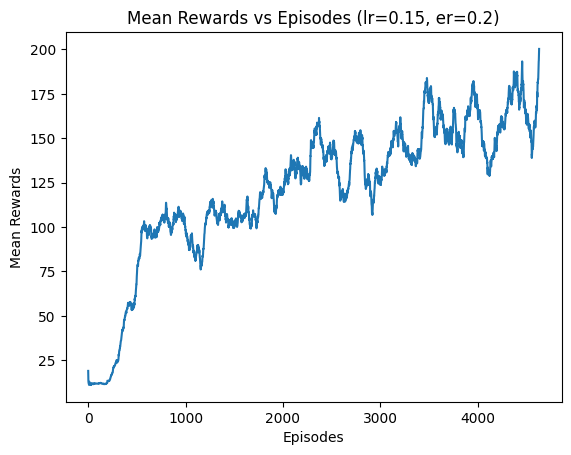

In [8]:
# Train the agent with lr = 0.15 and er = 0.2
agent = QLearningAgent(env)
agent.alpha = 0.15
agent.epsilon = 0.2
agent.train(min_rewards=200, plot=True)
plt.title(f'Mean Rewards vs Episodes (lr={0.15}, er={0.2})')
agent.save_model('cartpoleQLAgent.pkl')


# Task 2: Test the RL Agent

Demonstrate the effectiveness of the RL agent. Run for 100 episodes (reset the environment at the beginning of each episode) and plot the cumulative reward against all episodes in Jupyter. Print the average reward over the 100 episodes. The average reward should be larger than 195.   

## 2.1 Testing Q-learning Agent

Here we will load the pickle file containing the parameters for the Q-learning agent we have trained above.

Episode: 1 Rewards: 288.0
Episode: 2 Rewards: 285.0
Episode: 3 Rewards: 121.0
Episode: 4 Rewards: 69.0
Episode: 5 Rewards: 204.0
Episode: 6 Rewards: 175.0
Episode: 7 Rewards: 306.0
Episode: 8 Rewards: 526.0
Episode: 9 Rewards: 75.0
Episode: 10 Rewards: 87.0
Episode: 11 Rewards: 355.0
Episode: 12 Rewards: 289.0
Episode: 13 Rewards: 291.0
Episode: 14 Rewards: 91.0
Episode: 15 Rewards: 310.0
Episode: 16 Rewards: 225.0
Episode: 17 Rewards: 393.0
Episode: 18 Rewards: 98.0
Episode: 19 Rewards: 159.0
Episode: 20 Rewards: 201.0
Episode: 21 Rewards: 101.0
Episode: 22 Rewards: 89.0
Episode: 23 Rewards: 242.0
Episode: 24 Rewards: 281.0
Episode: 25 Rewards: 275.0
Episode: 26 Rewards: 92.0
Episode: 27 Rewards: 96.0
Episode: 28 Rewards: 211.0
Episode: 29 Rewards: 299.0
Episode: 30 Rewards: 311.0
Episode: 31 Rewards: 195.0
Episode: 32 Rewards: 92.0
Episode: 33 Rewards: 96.0
Episode: 34 Rewards: 125.0
Episode: 35 Rewards: 331.0
Episode: 36 Rewards: 328.0
Episode: 37 Rewards: 145.0
Episode: 38 Rewards:

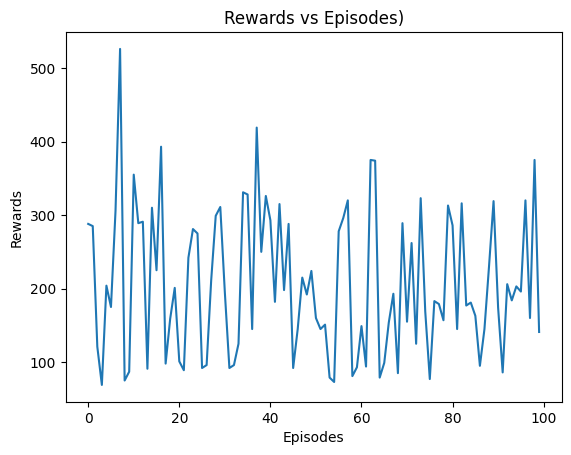

In [9]:
# Test the agent
env = gym.make('CartPole-v1')
agent = QLearningAgent(env)
agent.load_model('cartpoleQLAgent.pkl')
episode_results = agent.test(num_episodes=100, plot=True)

In [10]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 206.08
Is my agent good enough? True


# Task 3: Render

Render one episode played by the developed RL agent on Jupyter. Please refer to the sample code link for rendering code

In [12]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
env = RecordVideo(env, './video')
agent = QLearningAgent(env)
agent.load_model('cartpoleQLAgent.pkl')
agent.run_one_episode(is_training=False)
env.close()
show_video()

c:\Users\User\Documents\NTU WORK\SC3000-Projects\sc3000\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Moviepy - Building video c:\Users\User\Documents\NTU WORK\SC3000-Projects\Project1\video\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\User\Documents\NTU WORK\SC3000-Projects\Project1\video\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\User\Documents\NTU WORK\SC3000-Projects\Project1\video\rl-video-episode-0.mp4


---
# Comparison to Deep Q Network Agent with Replay

Now we will compare our Q learning model with another one with a different approach: deep Q learning with experience replay.

## 1.1 Development of DQN Agent

### Deep Q Learning
The network takes the agent's state as an input and returns the Q values for each of the actions. The maximum Q value is selected by the agent to perform the next action. We want to update our neural nets weights to reduce the error, calculated by taking the difference between our Q_target (maximum possible value from the next state) and Q_value (our current prediction of the Q-value):

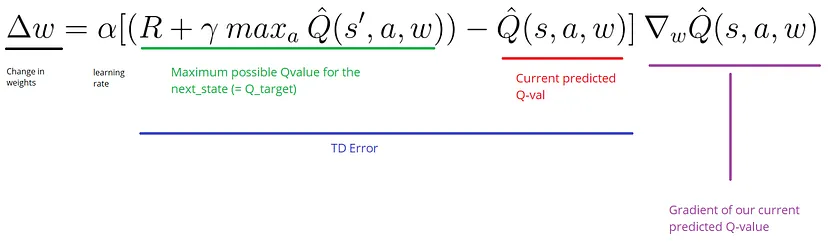

The target value, Q_target is estimated using the Bellman equation. The TD target is just the reward of taking that action at that state plus the discounted highest Q value for the next state:
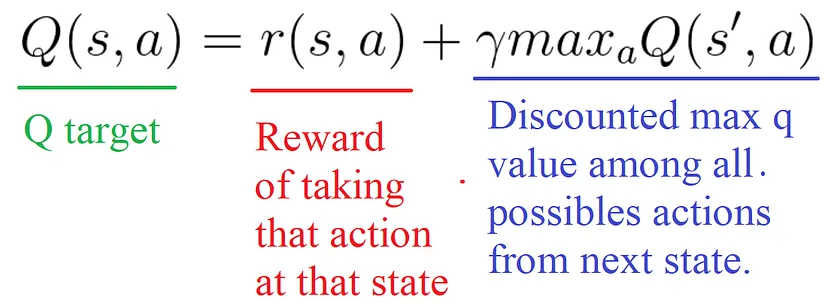

The Neural Network consists of 2 functions
*   `model.update` (while training) - calculates the mean squared error loss between the the target Q-values and the predicted Q-values. The optimizer is used to minimize the loss and update the weights.
*   `model.predict` (while training or after training) - uses the neural network model, returns the Q-values as a tensor


For this deep neural network, it consists of:

3 fully connected layers and a ReLU activation function in between each layer, where the model takes in the state as an input and outputs the predicted Q-values. 
> Although our network is shallow, the ReLU activation is still used regardless to tackle the vanishing gradient problem during backpropagation. The Adam optimizer, an adaptive learning rate optimization algorithm is also used due to its fast computational speed and little parameter requirements.

using the default **learning rate value** `lr = 0.001` in-line with the adam optimizer. The learning rate controls how quickly the model is adapted to the problem.

> A learning rate that is too large can cause the model to converge too quickly to a suboptimal solution, whereas a learning rate that is too small can cause the process to get stuck as the convergence happens very slowly and the algorithm takes a lot more time to converge.


### Implementation

First, we import the required libraries, then we implement our base Deep Q Neural Network model using pyTorch's neural network model.

In [15]:
import torch
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import torchvision.transforms as T
import numpy as np

import time

In [41]:
class DQL():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
            self.criterion = torch.nn.MSELoss()
            self.model = torch.nn.Sequential(
                            torch.nn.Linear(state_dim, hidden_dim),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim, hidden_dim*2),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim*2, action_dim)
                    )
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
    def update(self, state, y):
            """Update the weights of the network given a training sample. """
            y_pred = self.model(torch.Tensor(state))
            loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
    def predict(self, state):
            """ Compute Q values for all actions using the DQL. """
            with torch.no_grad():
                return self.model(torch.Tensor(state))

### Experience replay

Here we will exapand the DQL class with replay functionality.   

Experience replay is to improve network stability and make sure previous experiences are not discarded but used in training.

Experience replay stores the agent’s experiences in memory. Batches of experiences are randomly sampled from memory and are used to train the neural network. Such learning consists of two phases — gaining experience and updating the model. The size of the replay controls the number of experiences that are used for the network update. Memory is an array that stores the agent’s state, reward, and action, as well as whether the action finished the game and the next state.

In [17]:
# Expand DQL class with a replay function.
class DQN_replay(DQL):
    def replay(self, memory, size, gamma=0.9):
            #Try to improve replay speed
            if len(memory)>=size:
                batch = random.sample(memory,size)
                batch_t = list(map(list, zip(*batch))) #Transpose batch list
                states = batch_t[0]
                actions = batch_t[1]
                next_states = batch_t[2]
                rewards = batch_t[3]
                is_dones = batch_t[4]

                states = torch.Tensor(states)
                actions_tensor = torch.Tensor(actions)
                next_states = torch.Tensor(next_states)
                rewards = torch.Tensor(rewards)
                is_dones_tensor = torch.Tensor(is_dones)

                is_dones_indices = torch.where(is_dones_tensor==True)[0]

                all_q_values = self.model(states) # predicted q_values of all states
                all_q_values_next = self.model(next_states)
                #Update q values
                all_q_values[range(len(all_q_values)),actions]=rewards+gamma*torch.max(all_q_values_next, axis=1).values
                all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


                self.update(states.tolist(), all_q_values.tolist())

### Define helper functions for running model

Here we define the function for plotting graph and running the environment. We also defined an early stop mechanism to prevent overfitting.

In [39]:
# Function to plot graph
def plot_res(values, title=''):
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)

    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')

    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()
    print("Average reward: ", np.mean(values))

# Function to run Deep Q Learning
def run(env, model, episodes, gamma=0.9,
               epsilon=0.3, eps_decay=0.99,
               replay=False, replay_size=20,
               title = 'DQL', double=False,
               n_update=10, soft=False, verbose=True):
    """Deep Q Learning algorithm using the DQN. """
    final = []                  # Create a list to save the rewards per episode
    memory = []                 # Create a list to save the transitions
    episode_i=0                 # Create a counter for episodes
    sum_total_replay_time=0     # Create a counter for the replay time
    best_mean_reward = 0        # Update the best score
    early_stop_counter = 0      # Counter for early stop
    for episode in range(episodes):
        episode_i+=1
        if double and not soft:
            # Update target network every n_update steps
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()

        # Reset state
        state, _ = env.reset()
        done = False
        total = 0

        while not done:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()

            # Take action and add reward to total
            next_state, reward, done, _, _ = env.step(action)

            # Update total and memory
            total += reward
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state).tolist()

            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    model.update(state, q_values)
                break

            if replay:
                t0=time.time()
                # Update network weights using replay memory
                model.replay(memory, replay_size, gamma)
                t1=time.time()
                sum_total_replay_time+=(t1-t0)
            else:
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)

            state = next_state

        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        plot_res(final, title)

        if verbose:
            print("episode: {}, total reward: {}".format(episode_i, total))
            if replay:
                print("Average replay time:", sum_total_replay_time/episode_i)

        # Record best mean reward
        if total > best_mean_reward:
            best_mean_reward = total
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        
        # Early stop if last 10 episodes have reward lower than best mean reward and greater than 200
        if early_stop_counter > 10 and np.mean(final[-10:]) > 250:
            print(f"Early stopping at episode {episode_i}")
            break

    return final

### Choosing Hyper-parameters

We chose a reasonably high enough episode number of 300 for training to ensure the quality of the agent's learned policy without compromising too much on computational cost and time. This ensured a good balance between training stability, regularization and generalization performance.

In [22]:
# Number of states
n_state = env.observation_space.shape[0]
# Number of actions
n_action = env.action_space.n
# Number of episodes
episodes = 300
# Number of hidden nodes in the DQN
n_hidden = 50
# Learning rate
lr = 0.001

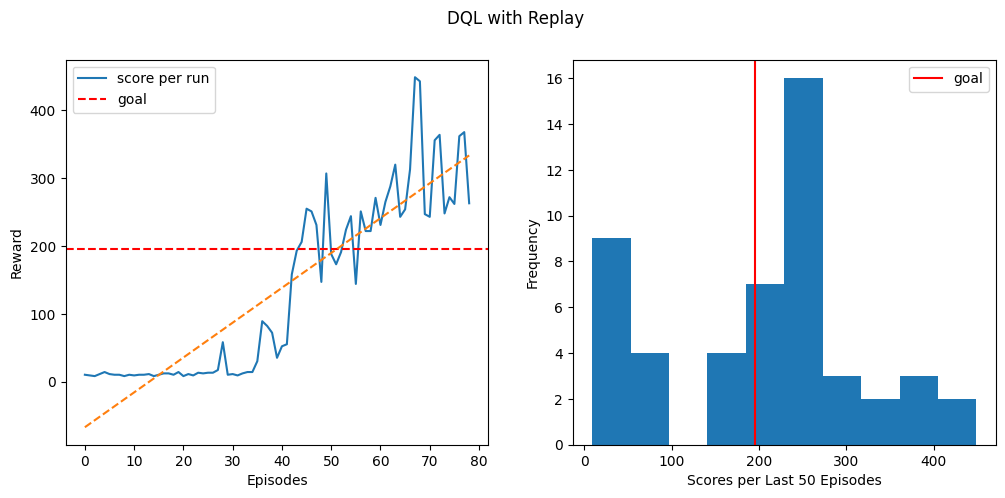

Average reward:  133.1012658227848
episode: 79, total reward: 263.0
Average replay time: 0.36389106436620783
Early stopping at episode 79


In [42]:
# Get replay results
env = gym.make('CartPole-v1')
dqn_replay = DQN_replay(n_state, n_action, n_hidden, lr)
replay = run(env, dqn_replay,
                    episodes, gamma=.9,
                    epsilon=0.2, replay=True,
                    title='DQL with Replay')

# Conclusion

In conclusion, we explored 2 different approach to solving the gym cartpole problem. Using basic Q learning and Deep Q Neural Network with replay.

Through our exploration, we found that basic Q learning is sifficient to achieve high rewards with enough training episodes. However, this requires large number of training episodes (around 5000+ in our experiment).

As compared with Deep Q neural network with replay, it was able to achieve the same reward with a significantly lesser amount of episodes (around 50+).

# References
* https://towardsdatascience.com/deep-q-learning-for-the-cartpole-44d761085c2f
